In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, make_scorer
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
from detection import SubjectData
from utils import train_subjects, test_subjects
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
RAND_STATE = 42

In [4]:
labels = pd.read_csv('./data/TrainLabels.csv')
y = labels['Prediction'].to_numpy()
print(y.shape)

(5440,)


In [24]:
def reduce_raw_features(raw_features, target_samples=340):
    
    # Χρησιμοποιήστε PCA πρώτα για μείωση διαστάσεων
    pca = PCA(n_components=0.95)
    reduced = pca.fit_transform(raw_features)
    
    # K-means clustering
    kmeans = KMeans(n_clusters=target_samples)
    labels = kmeans.fit_predict(reduced)
    
    # Αгрегаση (μέσος όρος κάθε cluster)
    aggregated = np.zeros((target_samples, raw_features.shape[1]))
    for i in range(target_samples):
        aggregated[i] = raw_features[labels == i].mean(axis=0)
    
    return aggregated

In [25]:
X = []
for subject in train_subjects:
    sd = SubjectData(subject, train=True)
    
    # Reduce raw_features from (3686, 64) to (340, 64)
    reduced_raw = reduce_raw_features(sd.raw_features)
    
    # Stack all features together
    subject_features = np.hstack((
        sd.is_short.reshape(-1, 1),          # (340, 1)
        sd.get_green_similarity(),           # (340, 8)
        sd.get_feedback_similarity(),        # (340, 17)
        reduced_raw,                         # (340, 64)
        sd.errp_features                     # (340, 80)
    ))
    
    X.append(subject_features)

X = np.vstack(X)
print(f"Final X shape: {X.shape}")

Final X shape: (5440, 170)


In [26]:
test_X = []
for subject in test_subjects:
    sd = SubjectData(subject, train=False)
    
    # Reduce raw_features from (3686, 64) to (340, 64)
    reduced_raw = reduce_raw_features(sd.raw_features)
    
    # Stack all features together
    subject_features = np.hstack((
        sd.is_short.reshape(-1, 1),          # (340, 1)
        sd.get_green_similarity(),           # (340, 8)
        sd.get_feedback_similarity(),        # (340, 17)
        reduced_raw,                         # (340, 64)
        sd.errp_features                     # (340, 80)
    ))
    
    test_X.append(subject_features)
test_X = np.vstack(test_X)
print(f"Final test_X shape: {test_X.shape}")

Final test_X shape: (3400, 170)


In [27]:
def get_session_and_trial(verbose=False):
    features = []
    for i in range(1, 5):
        for j in range(1, 61):
            features.append([i, j])
    for j in range(1, 101):
        features.append([5, j])
    features = np.array(features)
    if verbose: print(f'session_and_trial: {features.shape}')
    return features

def transform_data(X, verbose=False):
  extra_features = get_session_and_trial(verbose=verbose)
  extra_cols = []
  for i in range(X.shape[0] // extra_features.shape[0]):
    extra_cols.append(extra_features)
  extra_cols = np.array(extra_cols)
  extra_cols = extra_cols.reshape(extra_cols.shape[0] * extra_cols.shape[1], extra_cols.shape[2])
  if verbose: print(f'extra_cols: {extra_cols.shape}')
  final_X = np.hstack((extra_cols, X))
  return final_X

In [28]:
X = transform_data(X, verbose=True)

session_and_trial: (340, 2)
extra_cols: (5440, 2)


In [29]:
test_X = transform_data(test_X, verbose=True)

session_and_trial: (340, 2)
extra_cols: (3400, 2)


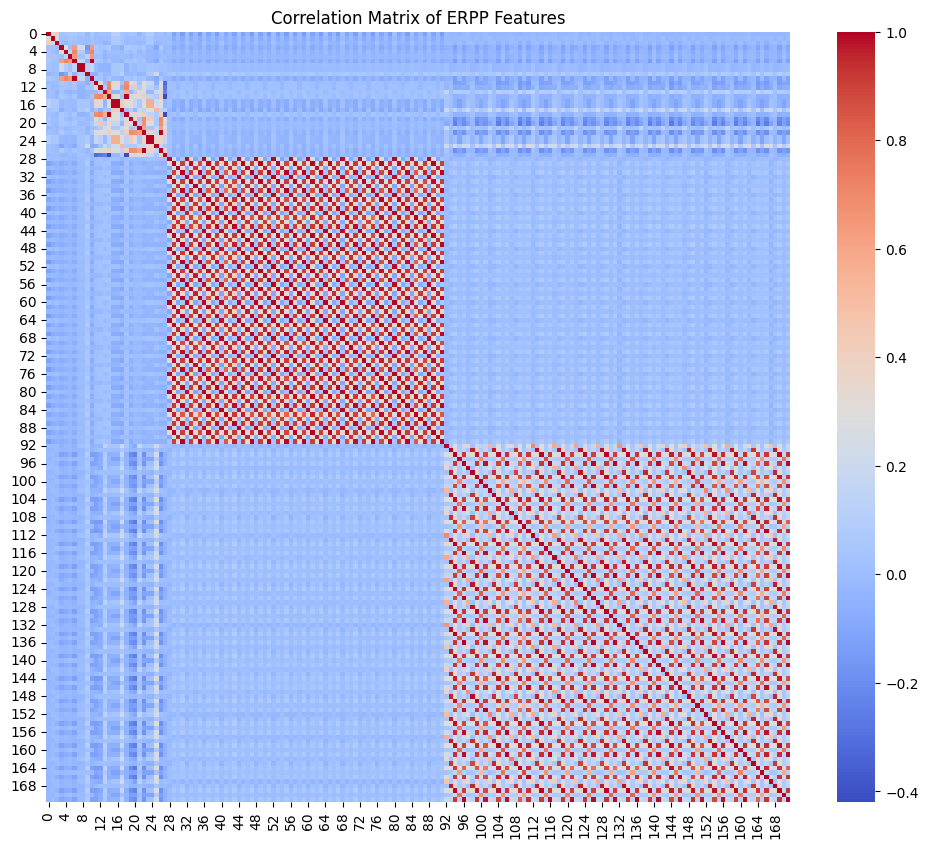

In [30]:
data_corr = pd.DataFrame(X)
corr_matrix = data_corr.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of ERPP Features')
plt.show()

In [46]:
def remove_high_correlation_columns_full_matrix(data, threshold=0.8, verbose=False):
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data)
    corr_matrix = data.corr().abs()
    to_drop = set()

    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                col_i = corr_matrix.columns[i]
                col_j = corr_matrix.columns[j]

                to_drop.add(col_j)
                if verbose:
                    print(f"Συσχέτιση {col_i} με {col_j}: {corr_matrix.iloc[i, j]:.2f} -> Αφαίρεση {col_j}")


    reduced_data = data.drop(columns=to_drop)
    return reduced_data

reduced_X = remove_high_correlation_columns_full_matrix(X, threshold=0.85, verbose=True)

Συσχέτιση 6 με 10: 1.00 -> Αφαίρεση 10
Συσχέτιση 7 με 8: 1.00 -> Αφαίρεση 8
Συσχέτιση 14 με 18: 1.00 -> Αφαίρεση 18
Συσχέτιση 15 με 16: 1.00 -> Αφαίρεση 16
Συσχέτιση 22 με 26: 1.00 -> Αφαίρεση 26
Συσχέτιση 23 με 24: 1.00 -> Αφαίρεση 24
Συσχέτιση 28 με 32: 0.99 -> Αφαίρεση 32
Συσχέτιση 28 με 36: 0.99 -> Αφαίρεση 36
Συσχέτιση 28 με 40: 0.98 -> Αφαίρεση 40
Συσχέτιση 28 με 44: 1.00 -> Αφαίρεση 44
Συσχέτιση 28 με 48: 1.00 -> Αφαίρεση 48
Συσχέτιση 28 με 52: 1.00 -> Αφαίρεση 52
Συσχέτιση 28 με 56: 1.00 -> Αφαίρεση 56
Συσχέτιση 28 με 60: 1.00 -> Αφαίρεση 60
Συσχέτιση 28 με 64: 1.00 -> Αφαίρεση 64
Συσχέτιση 28 με 68: 0.99 -> Αφαίρεση 68
Συσχέτιση 28 με 72: 0.99 -> Αφαίρεση 72
Συσχέτιση 28 με 76: 0.99 -> Αφαίρεση 76
Συσχέτιση 28 με 80: 1.00 -> Αφαίρεση 80
Συσχέτιση 28 με 84: 0.98 -> Αφαίρεση 84
Συσχέτιση 28 με 88: 1.00 -> Αφαίρεση 88
Συσχέτιση 29 με 31: 0.91 -> Αφαίρεση 31
Συσχέτιση 29 με 33: 0.99 -> Αφαίρεση 33
Συσχέτιση 29 με 35: 0.88 -> Αφαίρεση 35
Συσχέτιση 29 με 37: 0.99 -> Αφαίρεση 37
Συσχ

In [47]:
reduced_test_X = remove_high_correlation_columns_full_matrix(test_X, threshold=0.85, verbose=True)

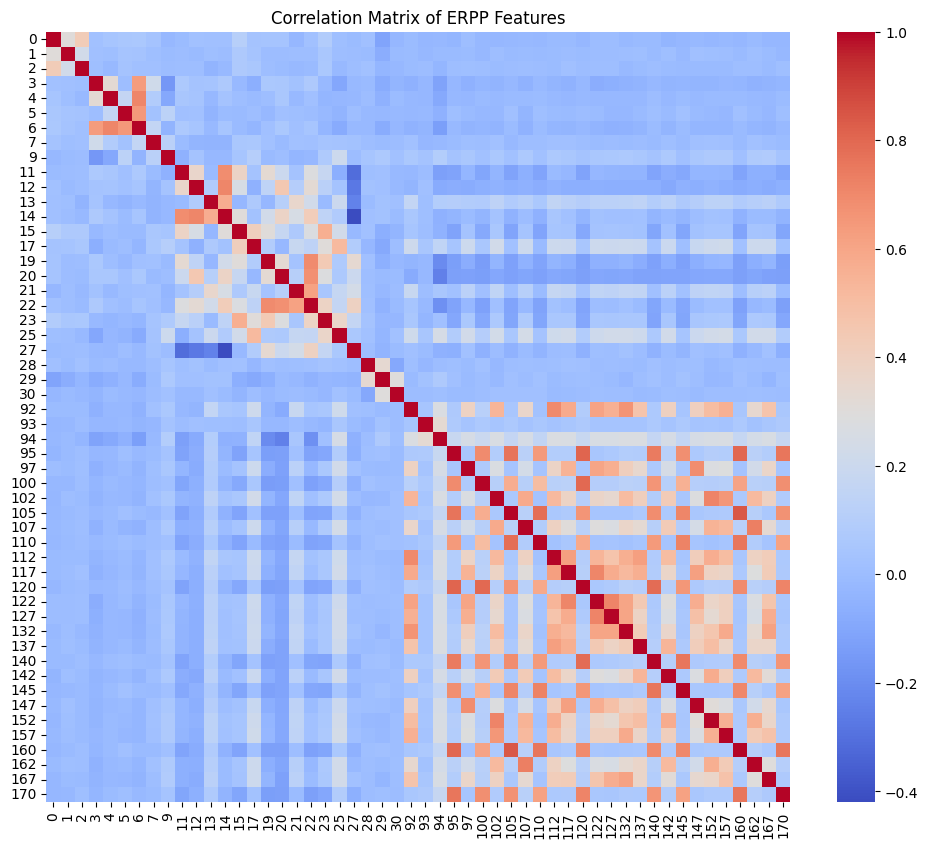

In [45]:
data_corr = pd.DataFrame(reduced_X)
corr_matrix = data_corr.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of ERPP Features')
plt.show()

In [48]:
print(reduced_X.shape)

(5440, 52)


In [61]:
# pca on reduced_X 
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(reduced_X)
print(f"X_pca shape: {X_pca.shape}")


X_pca shape: (5440, 3)


In [54]:
# Optional: print cumulative variance explained
cumulative_variance = pca.explained_variance_ratio_.cumsum()
print("Cumulative Variance Explained:\n", cumulative_variance)

Cumulative Variance Explained:
 [0.40227459 0.69433556 0.95837184]


In [65]:
X_train, X_val, y_train, y_val = train_test_split(reduced_X, y, test_size=0.3, random_state=RAND_STATE)
print(f'X_train: {X_train.shape}\nX_val: {X_val.shape}')

X_train: (3808, 52)
X_val: (1632, 52)


In [66]:
smote = SMOTE(random_state=RAND_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f'X_train_smote: {X_train_smote.shape}')

adasyn = ADASYN(random_state=RAND_STATE)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
print(f'X_train_adasyn: {X_train_adasyn.shape}')

X_train_smote: (5356, 52)
X_train_adasyn: (5457, 52)


In [67]:
def grid_search_rf(X_train, y_train, X_val, y_val, grid, cv=5):
  gscv = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
  )
  model = gscv.fit(X_train, y_train)
  print('Grid Train:')
  print(f'| Best parameters: {model.best_params_}')
  print(f'| Best score: {model.best_score_}')

  y_proba = model.predict_proba(X_val)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_val, y_proba)
  final_auc = auc(fpr, tpr)
  print("| Final AUC score on val set:", final_auc)
  print('-' * 30)


In [68]:
rf_param_grid = {
    'n_estimators': [100, 400, 550],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2, 4],
    #'max_features': ['sqrt', 'log2', None],
}
print("-----[ SMOTE ]-----")
grid_search_rf(X_train_smote, y_train_smote, X_val, y_val, rf_param_grid)

print("-----[ ADASYN ]-----")
grid_search_rf(X_train_adasyn, y_train_adasyn, X_val, y_val, rf_param_grid)

-----[ SMOTE ]-----
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Grid Train:
| Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
| Best score: 0.8913248584806475
| Final AUC score on val set: 0.6733417420982342
------------------------------
-----[ ADASYN ]-----
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Grid Train:
| Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
| Best score: 0.8975115371731297
| Final AUC score on val set: 0.6798458599198695
------------------------------


In [69]:
optimized_param_grid = {
    'n_estimators': [300, 350, 400, 450],
    'max_depth': [None, 2],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}

#print("-----[ SMOTE ]-----")
#grid_search_rf(X_train_smote, y_train_smote, X_val, y_val, optimized_param_grid)

print("-----[ ADASYN ]-----")
grid_search_rf(X_train_adasyn, y_train_adasyn, X_val, y_val, optimized_param_grid)

-----[ ADASYN ]-----
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Grid Train:
| Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 400}
| Best score: 0.9020350690528017
| Final AUC score on val set: 0.680700957115299
------------------------------


In [ ]:
best_param_grid = {
    'n_estimators': [350, 400, 450],
    'max_depth': [None],
    'min_samples_split': [3, 4, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}
print("-----[ ADASYN ]-----")
grid_search_rf(X_train_adasyn, y_train_adasyn, X_val, y_val, best_param_grid)

-----[ ADASYN ]-----
Fitting 5 folds for each of 54 candidates, totalling 270 fits
